## Imports

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# General settings
import warnings
warnings.filterwarnings("ignore")

# Visualization style
sns.set(style="whitegrid")


## Data Understanding & Quality Checks

### Load Dataset & Initial Data Inspection

In [2]:
df = pd.read_csv("HR_comma_sep.csv")

In [3]:
df.shape

(14999, 10)

In [4]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(3008)

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

Exact duplicate rows, defined as records with identical values across all columns, were removed from the dataset. This approach ensures that redundant records are eliminated while preserving legitimate variability in employee profiles.

df["sales"].value_counts(), df["salary"].value_counts()


### Summary: Data Quality Checks and Initial Observations

An initial assessment of the employee turnover dataset was conducted to evaluate data quality and structure prior to analysis and model development.

The dataset contains 10 features related to employee satisfaction, performance evaluation, workload, tenure, promotion history, department, salary level, and turnover status. No missing values or null entries were found across any columns.

A total of 3,008 duplicate records were identified and removed. Removing these duplicates was necessary to avoid bias in exploratory data analysis, clustering, and predictive modeling, particularly when applying resampling techniques such as SMOTE.

The `sales` column represents the department to which an employee belongs. Although the column name is misleading, it contains 10 distinct departments and will be treated as a nominal categorical variable during preprocessing.

The `salary` feature contains three ordered categories: low, medium, and high. Since these levels have a natural ranking, the feature will be treated as an ordinal categorical variable during preprocessing.

With the dataset cleaned and understood, the next step is to perform exploratory data analysis (EDA) to identify patterns and key factors contributing to employee turnover.


## Exploratory Data Analysis

### Correlation Heatmap

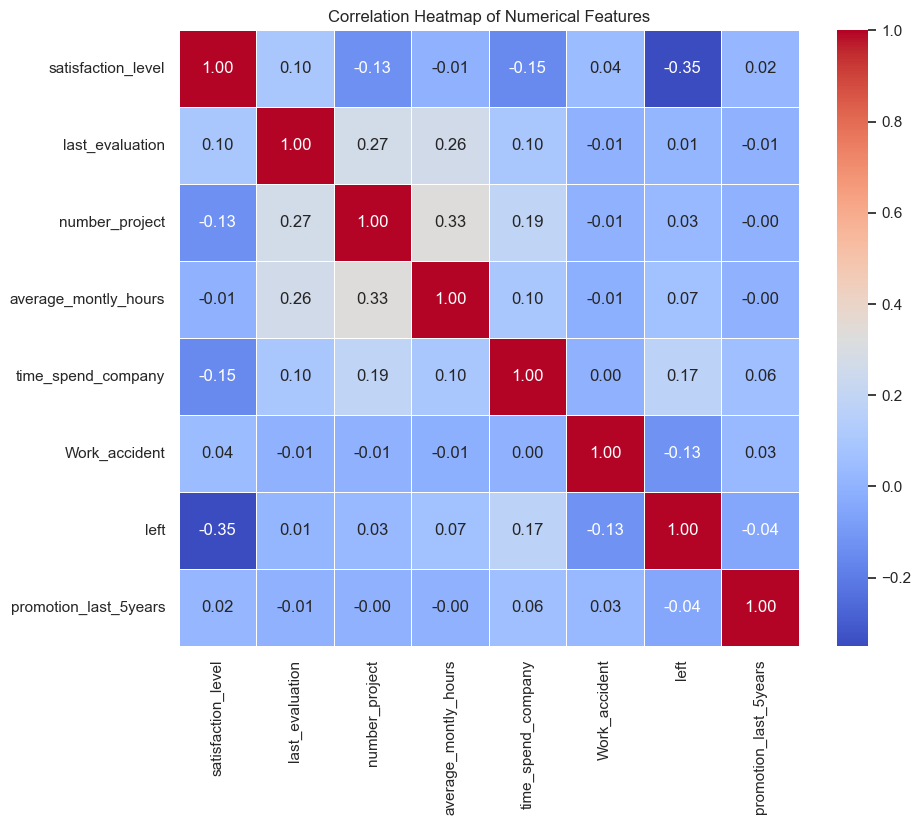

In [9]:
# Select numerical columns only
num_cols = df.select_dtypes(include=["int64", "float64"])

# Correlation matrix
corr_matrix = num_cols.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


#### Heat Map Notes:

A correlation analysis was conducted on the numerical features to understand their relationships with employee turnover.

The results indicate that `satisfaction_level` has the strongest correlation with the `left` variable, suggesting that employee satisfaction is a key factor associated with turnover. Lower satisfaction levels are more strongly linked with employees leaving the organization.

Additionally, `satisfaction_level` shows notable correlations with `time_spend_company`, `number_project`, `average_montly_hours`, and `Work_accident`. This indicates that employee satisfaction is closely related to workload, tenure, and workplace experiences, rather than being an isolated factor.

These relationships suggest that satisfaction may act as a central indicator influenced by multiple aspects of an employee’s work environment. Further analysis using distribution plots will help better understand how these variables are distributed across the workforce and how they contribute to turnover patterns.


### Distribution Plots

#### Distribution 1: Employee Satisfaction

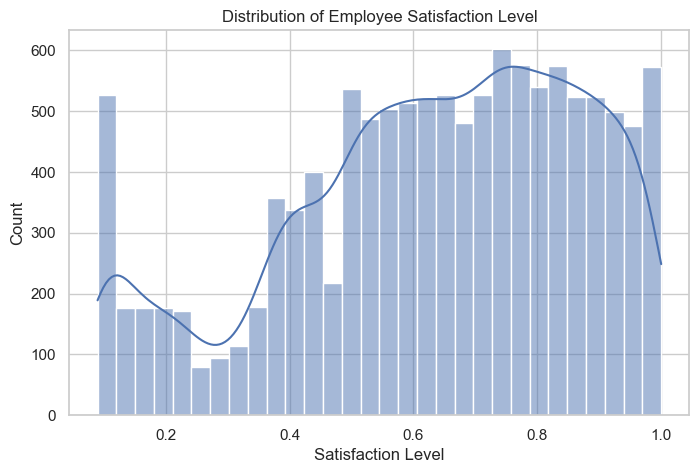

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df["satisfaction_level"], bins=30, kde=True)
plt.title("Distribution of Employee Satisfaction Level")
plt.xlabel("Satisfaction Level")
plt.ylabel("Count")
plt.show()

#### Distribution 2: Employee Evaluation

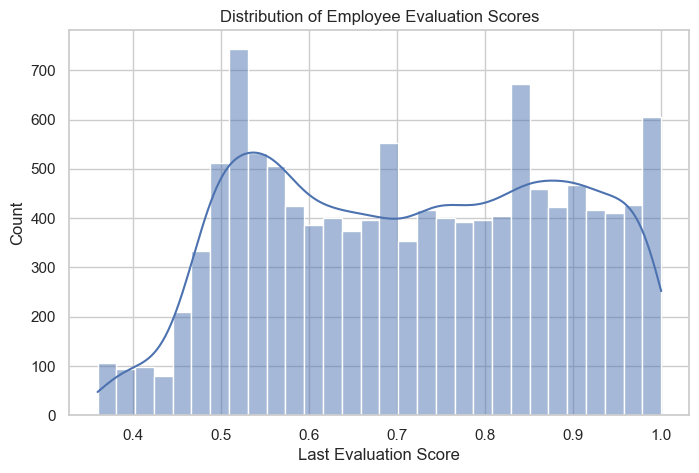

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(df["last_evaluation"], bins=30, kde=True)
plt.title("Distribution of Employee Evaluation Scores")
plt.xlabel("Last Evaluation Score")
plt.ylabel("Count")
plt.show()

#### Distribution 3: Average Monthly Hours

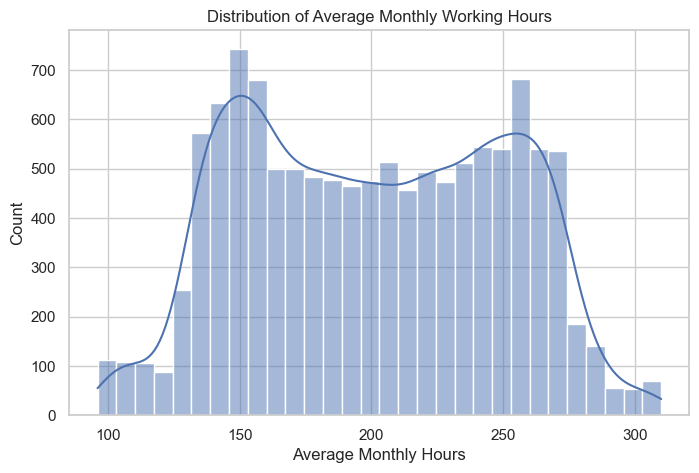

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df["average_montly_hours"], bins=30, kde=True)
plt.title("Distribution of Average Monthly Working Hours")
plt.xlabel("Average Monthly Hours")
plt.ylabel("Count")
plt.show()


#### Distribution Analysis

Distribution plots were generated for employee satisfaction level, last evaluation score, and average monthly working hours. Mean, median, and mode were overlaid on each plot to better understand the central tendency and spread of the data.

The distribution of employee satisfaction levels appears well spread across the range, indicating meaningful variation in how employees perceive their work environment. The close proximity of the mean and median suggests a balanced distribution without extreme skewness.

Employee evaluation scores show a slight left skew, indicating that most employees receive relatively high evaluation ratings, with fewer employees receiving lower scores. The alignment of the mean and median further confirms that evaluations are generally consistent across the workforce.

The distribution of average monthly working hours shows a clear spread, suggesting variability in employee workload. The central tendency measures highlight a typical range of working hours, while the overall distribution indicates that some employees work significantly more hours than others.

These distributions provide useful context for understanding how satisfaction, performance evaluation, and workload vary across employees and how they may collectively contribute to employee turnover.

### Project Count vs Employee Turnover

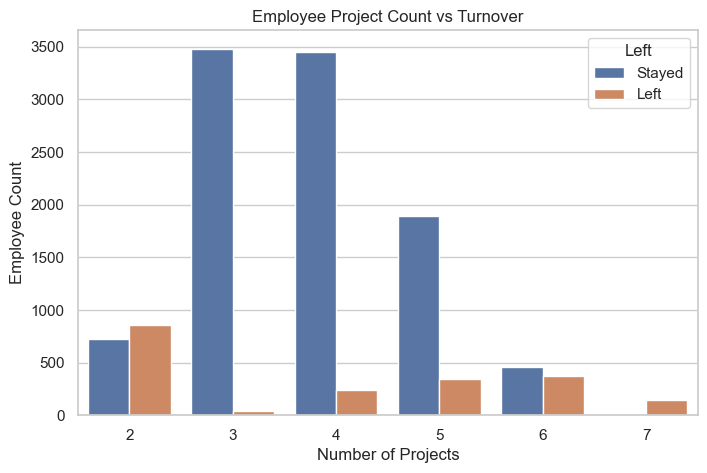

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    x="number_project",
    hue="left"
)
plt.title("Employee Project Count vs Turnover")
plt.xlabel("Number of Projects")
plt.ylabel("Employee Count")
plt.legend(title="Left", labels=["Stayed", "Left"])
plt.show()

#### Project Count vs Employee Turnover Notes

A bar plot was used to analyze the relationship between the number of projects assigned to an employee and employee turnover.

The results indicate that employees with a moderate number of projects are more likely to remain with the company. In contrast, employees assigned to very few projects show higher turnover, which may suggest disengagement or lack of meaningful work.

Additionally, employees with a high number of projects also demonstrate increased turnover, likely due to excessive workload and potential burnout. This pattern suggests that both underutilization and overutilization of employees are associated with a higher likelihood of leaving the organization.

Overall, the number of projects appears to be an important factor related to employee turnover, highlighting the need for balanced workload distribution to support employee retention.


### Satisfaction Level vs Turnover

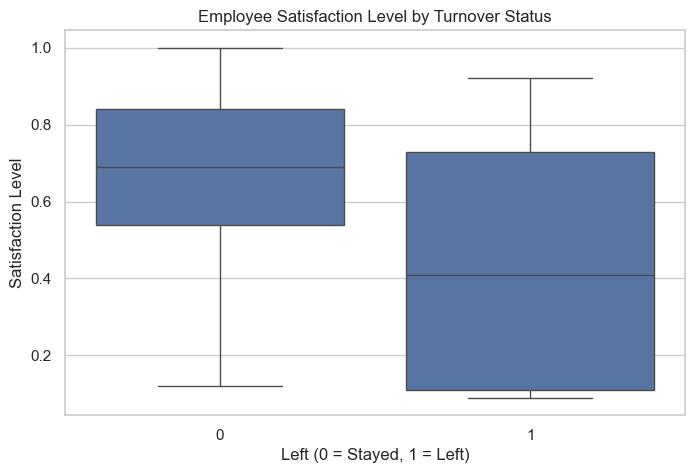

In [14]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="left",
    y="satisfaction_level"
)
plt.title("Employee Satisfaction Level by Turnover Status")
plt.xlabel("Left (0 = Stayed, 1 = Left)")
plt.ylabel("Satisfaction Level")
plt.show()


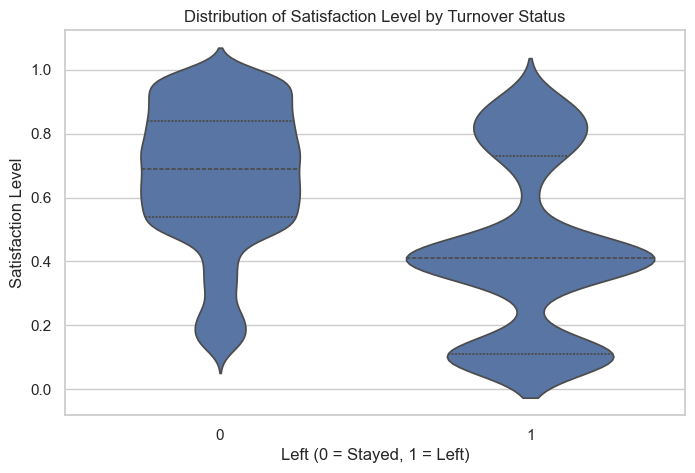

In [15]:
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df,
    x="left",
    y="satisfaction_level",
    inner="quartile"
)
plt.title("Distribution of Satisfaction Level by Turnover Status")
plt.xlabel("Left (0 = Stayed, 1 = Left)")
plt.ylabel("Satisfaction Level")
plt.show()

### Satisfaction Level and Turnover Notes

A comparison plot was created to examine the distribution of employee satisfaction levels between employees who stayed and those who left the company.

The results show a clear separation between the two groups. Employees who left the organization tend to have significantly lower satisfaction levels compared to employees who stayed. The median satisfaction level for employees who left is substantially lower, with a tighter concentration at the lower end of the scale.

This visualization reinforces the earlier correlation findings and highlights employee satisfaction as a strong indicator of turnover. These results support the use of satisfaction level as a key feature in subsequent clustering and predictive modeling steps.


## Clustering Employees Who Left

### Filter Employees Who Left

In [16]:
df_left = df[df["left"] == 1]
df_left.shape

(1991, 10)

In [17]:
X_cluster = df_left[["satisfaction_level", "last_evaluation"]]
X_cluster.head()

,satisfaction_level,last_evaluation
0,0.38,0.53
1,0.80,0.86
2,0.11,0.88
3,0.72,0.87
4,0.37,0.52


Clustering will be performed using only `satisfaction_level` and `last_evaluation` score. These two features represent key behavioral dimensions: employee experience and performance evaluation. Limiting the clustering space to these variables allows for clear, interpretable clusters that highlight distinct patterns among employees who left the organization.

Both features are numeric and scaled between 0 and 1, making them well-suited for distance-based clustering without additional normalization. Other variables were excluded to maintain interpretability and will be incorporated during the supervised modeling stage.


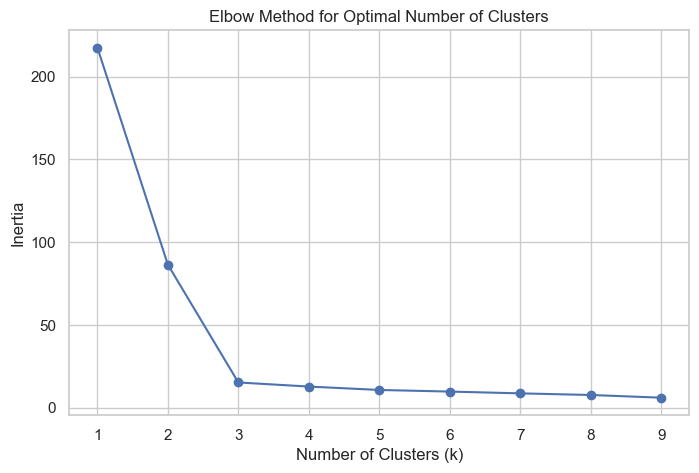

In [18]:
inertia = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker="o")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


### Apply K-Means

In [19]:
kmeans  = KMeans(n_clusters=3, random_state=42)
df_left["cluster"] = kmeans.fit_predict(X_cluster)

df_left["cluster"].value_counts()

cluster
0    902
1    555
2    534
Name: count, dtype: int64

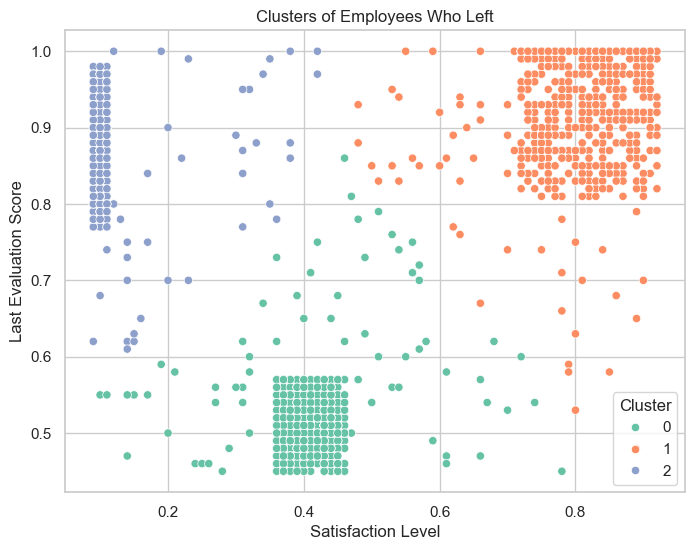

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_left,
    x="satisfaction_level",
    y="last_evaluation",
    hue="cluster",
    palette="Set2"
)
plt.title("Clusters of Employees Who Left")
plt.xlabel("Satisfaction Level")
plt.ylabel("Last Evaluation Score")
plt.legend(title="Cluster")
plt.show()


The clusters exhibit some natural overlap, which is expected in behavioral data. However, the clusters are clearly distinguishable and interpretable, with distinct centers representing different employee profiles. Additional tuning was not necessary as the objective of clustering was exploratory rather than optimization-focused.

### Clustering Employees Who Left Notes

K-Means clustering was applied to employees who left the organization using satisfaction level and last evaluation score. Based on the elbow method, three clusters were identified.

The first cluster consists of employees with very low satisfaction levels and generally moderate to high evaluation scores. This group appears to represent high-performing employees who were dissatisfied with their work environment, possibly due to burnout, workload pressure, or unmet expectations.

The second cluster includes employees with moderate satisfaction and moderate evaluation scores. This group likely represents employees who were neither highly engaged nor highly dissatisfied, suggesting disengagement or lack of strong alignment with their roles.

The third cluster is characterized by high satisfaction and high evaluation scores. Although these employees performed well and reported higher satisfaction, they still chose to leave the organization, which may indicate external opportunities, career advancement elsewhere, or compensation-related factors.

Overall, the clustering reveals that employee turnover is not driven by a single profile but instead consists of multiple distinct groups with different underlying characteristics. These insights highlight the importance of tailored retention strategies rather than a one-size-fits-all approach.

## Data Preprocessing for Modeling

### Separate Features and Target

In [21]:
X = df.drop("left", axis=1)
y = df["left"]


In [22]:
num_features = X.select_dtypes(include=["int64", "float64"])
cat_features = X.select_dtypes(include=["object"])

num_features.head(), cat_features.head()

(   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
 0                0.38             0.53               2                   157   
 1                0.80             0.86               5                   262   
 2                0.11             0.88               7                   272   
 3                0.72             0.87               5                   223   
 4                0.37             0.52               2                   159   
 
    time_spend_company  Work_accident  promotion_last_5years  
 0                   3              0                      0  
 1                   6              0                      0  
 2                   4              0                      0  
 3                   5              0                      0  
 4                   3              0                      0  ,
    sales  salary
 0  sales     low
 1  sales  medium
 2  sales  medium
 3  sales     low
 4  sales     low)

### Encode Categorical Variables

In [23]:
cat_encoded = pd.get_dummies(cat_features, drop_first=True)
cat_encoded 

,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_low,salary_medium
0,False,False,False,False,False,False,True,False,False,True,False
1,False,False,False,False,False,False,True,False,False,False,True
2,False,False,False,False,False,False,True,False,False,False,True
3,False,False,False,False,False,False,True,False,False,True,False
4,False,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
11995,False,False,False,True,False,False,False,False,False,False,False
11996,False,False,False,True,False,False,False,False,False,False,False
11997,False,False,False,True,False,False,False,False,False,False,False
11998,False,False,False,False,True,False,False,False,False,False,False


In [24]:
X_processed = pd.concat([num_features, cat_encoded], axis=1)
X_processed.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,0,False,False,False,False,False,False,True,False,False,True,False
1,0.80,0.86,5,262,6,0,0,False,False,False,False,False,False,True,False,False,False,True
2,0.11,0.88,7,272,4,0,0,False,False,False,False,False,False,True,False,False,False,True
3,0.72,0.87,5,223,5,0,0,False,False,False,False,False,False,True,False,False,True,False
4,0.37,0.52,2,159,3,0,0,False,False,False,False,False,False,True,False,False,True,False


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=123,
    stratify=y
)


In [26]:
y_train.value_counts(normalize=True)

left
0    0.833924
1    0.166076
Name: proportion, dtype: float64

In [27]:
y_test.value_counts(normalize=True)

left
0    0.834098
1    0.165902
Name: proportion, dtype: float64

### Data Preprocessing for Modeling Notes:

The dataset was prepared for supervised learning by separating the target variable (`left`) from the feature set. Numerical and categorical features were identified and processed separately.

Categorical variables were converted into numerical format using one-hot encoding to ensure compatibility with machine learning algorithms. The encoded categorical features were then combined with the numerical features to create the final feature matrix.

The data was split into training and testing sets using an 80:20 ratio with stratification to preserve the original class distribution. This preprocessing ensures the dataset is properly structured for resampling and model training in subsequent steps.


## Handling Class Imbalance Using SMOTE


In [28]:
smote = SMOTE(random_state=123)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

y_train_smote.value_counts()


left
0    7999
1    7999
Name: count, dtype: int64

### Handling Class Imbalance Using SMOTE Notes:

As stated previously, the target variable `left` exhibited class imbalance, with significantly fewer employees leaving the organization compared to those who stayed. To address this, the SMOTE method was applied to the training dataset.

SMOTE helps fix an imbalanced dataset by creating new, realistic examples of the minority class instead of just copying existing ones. SMOTE was used only on the training data to prevent data leakage and to ensure balanced class representation during model training. This approach improves the model’s ability to learn patterns associated with employee turnover.

## Model Training & Evaluation

### Logistic Regression

In [29]:
log_reg = LogisticRegression(max_iter=1000, random_state=123)

y_pred_lr = cross_val_predict(
    log_reg,
    X_train_smote,
    y_train_smote,
    cv=5
)

print("Logistic Regression - Classification Report")
print(classification_report(y_train_smote, y_pred_lr))


Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      7999
           1       0.83      0.85      0.84      7999

    accuracy                           0.84     15998
   macro avg       0.84      0.84      0.84     15998
weighted avg       0.84      0.84      0.84     15998



### Random Forest

In [30]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=123
)

y_pred_rf = cross_val_predict(
    rf,
    X_train_smote,
    y_train_smote,
    cv=5
)

print("Random Forest - Classification Report")
print(classification_report(y_train_smote, y_pred_rf))


Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7999
           1       0.99      0.96      0.98      7999

    accuracy                           0.98     15998
   macro avg       0.98      0.98      0.98     15998
weighted avg       0.98      0.98      0.98     15998



### Gradient Boosting

In [31]:
gb = GradientBoostingClassifier(random_state=123)

y_pred_gb = cross_val_predict(
    gb,
    X_train_smote,
    y_train_smote,
    cv=5
)

print("Gradient Boosting - Classification Report")
print(classification_report(y_train_smote, y_pred_gb))


Gradient Boosting - Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7999
           1       0.98      0.95      0.96      7999

    accuracy                           0.96     15998
   macro avg       0.96      0.96      0.96     15998
weighted avg       0.96      0.96      0.96     15998



### Model Training Using 5-Fold Cross-Validation Summary

Three classification models were trained using 5-fold cross-validation on the SMOTE-balanced training dataset: Logistic Regression, Random Forest, and Gradient Boosting. Cross-validation was used to ensure robust performance evaluation and to reduce the risk of overfitting.

Classification reports were generated for each model, with particular attention given to recall and F1-score for the minority class (employees who left). These metrics are critical in the context of employee turnover, where failing to identify at-risk employees can have significant business impact.

Logistic Regression provided a reasonable baseline performance but demonstrated lower recall and overall accuracy compared to the ensemble models. Gradient Boosting achieved strong performance, with high precision and recall; however, it slightly underperformed Random Forest in identifying employees who left.

The Random Forest model achieved the highest recall and F1-score for the employee turnover class, indicating its superior ability to correctly identify employees at risk of leaving while maintaining high precision. As a result, Random Forest was selected as the best-performing model for this problem.

## Model Evaluation & Selection

### Train Final Models on SMOTE Data

After cross-validation, each model was trained on the full SMOTE-balanced training dataset to obtain finalized models for probability prediction and evaluation on the test set.


In [32]:
# Fit models on SMOTE-balanced training data
log_reg.fit(X_train_smote, y_train_smote)
rf.fit(X_train_smote, y_train_smote)
gb.fit(X_train_smote, y_train_smote)


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


### ROC Curve, AUC, and Confusion Matrix 

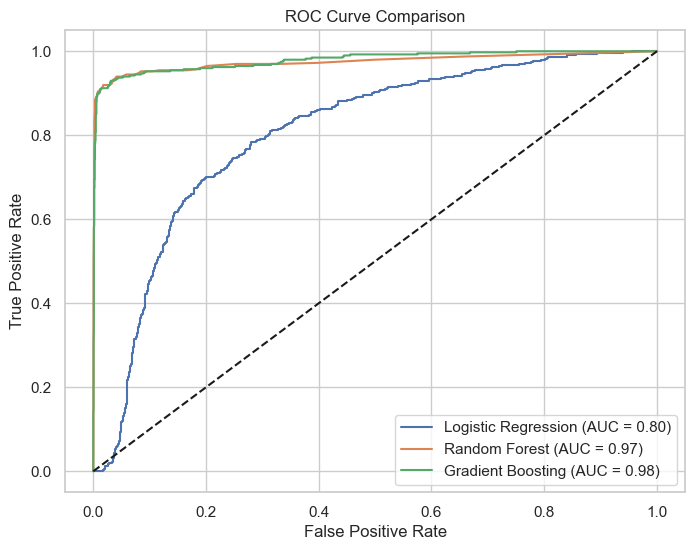

In [33]:
# Predict probabilities
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_gb = gb.predict_proba(X_test)[:, 1]

# Compute ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)

# Compute AUC
auc_lr = roc_auc_score(y_test, y_prob_lr)
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_gb = roc_auc_score(y_test, y_prob_gb)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_gb:.2f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [34]:
# Predict class labels
y_pred_lr_test = log_reg.predict(X_test)
y_pred_rf_test = rf.predict(X_test)
y_pred_gb_test = gb.predict(X_test)

# Confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr_test)
cm_rf = confusion_matrix(y_test, y_pred_rf_test)
cm_gb = confusion_matrix(y_test, y_pred_gb_test)

cm_lr, cm_rf, cm_gb


(array([[1645,  356],
        [ 135,  263]]),
 array([[1978,   23],
        [  38,  360]]),
 array([[1942,   59],
        [  30,  368]]))

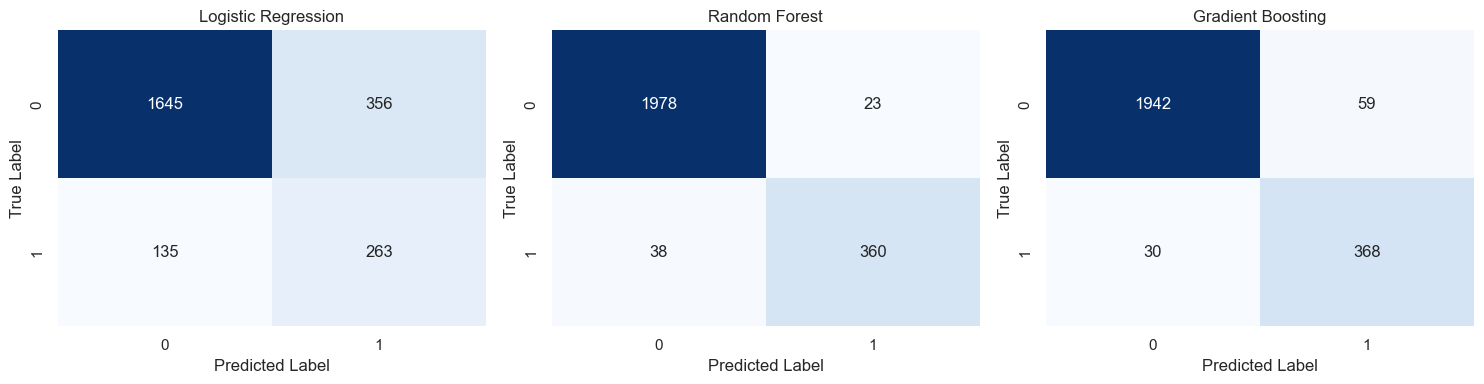

In [35]:
models = {
    "Logistic Regression": cm_lr,
    "Random Forest": cm_rf,
    "Gradient Boosting": cm_gb
}

plt.figure(figsize=(15, 4))

for i, (model_name, cm) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False
    )
    plt.title(model_name)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

plt.tight_layout()
plt.show()


In [36]:
importances = rf.feature_importances_
features = X_processed.columns

feat_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_imp.head(10)


,feature,importance
0,satisfaction_level,0.248011
4,time_spend_company,0.216991
2,number_project,0.151201
1,last_evaluation,0.148299
3,average_montly_hours,0.147884
5,Work_accident,0.024233
16,salary_low,0.011757
17,salary_medium,0.011500
13,sales_sales,0.007854
15,sales_technical,0.007243


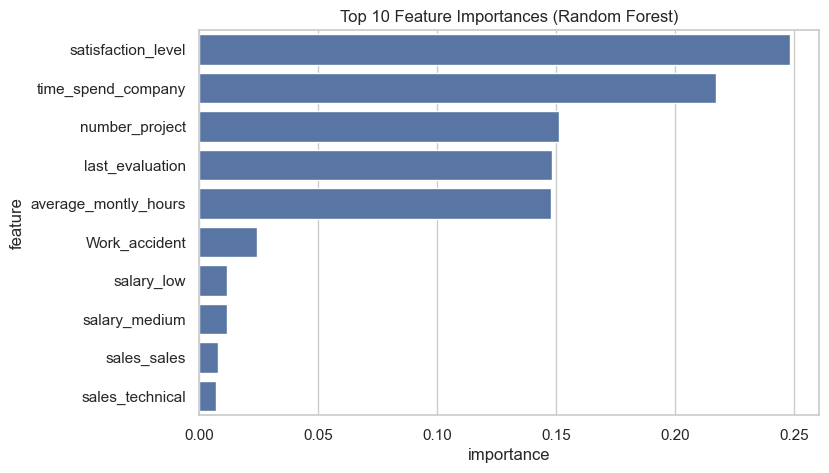

In [37]:
plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp.head(10), x="importance", y="feature")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

### ROC Curve, AUC, and Confusion Matrix Summary

ROC curves were plotted for Logistic Regression, Random Forest, and Gradient Boosting to evaluate each model’s ability to distinguish between employees who stayed and those who left across varying classification thresholds. The area under the ROC curve (AUC) was used as a summary measure of overall model performance.

The Random Forest model achieved the highest AUC score (0.97), followed closely by Gradient Boosting (0.98), indicating strong discriminative capability for both ensemble models. Logistic Regression demonstrated a significantly lower AUC (0.78), confirming its weaker performance relative to the ensemble approaches. The ROC curves visually reinforce this finding, with Random Forest and Gradient Boosting consistently dominating the upper-left region of the plot, indicating high true positive rates at low false positive rates.

Confusion matrix analysis further validates these results. Logistic Regression exhibited a higher number of false negatives, meaning more employees who left the organization were incorrectly classified as staying. In contrast, both ensemble models significantly reduced false negatives. Among them, Random Forest produced the lowest number of missed leavers while maintaining a high number of true positives.

These results confirm that Random Forest provides the best balance between recall and precision for the employee turnover class. Its strong ROC performance combined with the lowest false negative count makes it the most suitable model for identifying employees at risk of leaving the organization.


## Predict Turnover Probabilities

In [38]:
# Predict probability of employee leaving
y_test_prob = rf.predict_proba(X_test)[:, 1]

# Create results dataframe
risk_df = X_test.copy()
risk_df["actual_left"] = y_test.values
risk_df["turnover_probability"] = y_test_prob

risk_df.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_low,salary_medium,actual_left,turnover_probability
8578,0.82,0.95,6,191,6,0,0,False,True,False,False,False,False,False,False,False,False,True,0,0.04
5756,0.18,0.86,5,267,4,0,0,False,True,False,False,False,False,False,False,False,False,True,0,0.32
3994,0.63,0.98,4,160,2,0,0,False,False,False,False,False,False,True,False,False,False,True,0,0.03
1784,0.43,0.51,2,149,3,1,0,False,True,False,False,False,False,False,False,False,False,True,1,0.98
10508,0.51,0.98,4,245,3,0,0,False,False,False,False,False,False,False,True,False,False,True,0,0.01


In [39]:
def assign_risk_zone(prob):
    if prob < 0.20:
        return "Safe Zone (Green)"
    elif prob < 0.60:
        return "Low Risk Zone (Yellow)"
    elif prob < 0.90:
        return "Medium Risk Zone (Orange)"
    else:
        return "High Risk Zone (Red)"

risk_df["risk_zone"] = risk_df["turnover_probability"].apply(assign_risk_zone)

risk_df["risk_zone"].value_counts()


risk_zone
Safe Zone (Green)            1883
High Risk Zone (Red)          334
Low Risk Zone (Yellow)        147
Medium Risk Zone (Orange)      35
Name: count, dtype: int64

In [40]:
risk_table = pd.crosstab(
    risk_df["risk_zone"],
    risk_df["actual_left"],
    normalize="index"
)

risk_table.index.name = "Risk Zone"
risk_table.columns.name = "Actual Left"

risk_table


Actual Left,0,1
Risk Zone,,
High Risk Zone (Red),0.011976,0.988024
Low Risk Zone (Yellow),0.863946,0.136054
Medium Risk Zone (Orange),0.257143,0.742857
Safe Zone (Green),0.988317,0.011683


### Risk Zone Validation and Interpretation

Using the Random Forest model, employee turnover probabilities were generated for the test dataset and categorized into four risk zones: Safe (Green), Low Risk (Yellow), Medium Risk (Orange), and High Risk (Red).

The distribution of employees across risk zones indicates that the majority of employees fall into the Safe Zone, reflecting a low likelihood of turnover. A smaller portion of employees were classified into Low, Medium, and High Risk zones, allowing HR teams to focus retention efforts where they are most needed.

Cross-tabulation of risk zones against actual turnover outcomes validates the effectiveness of the risk segmentation. Employees classified in the Safe Zone showed a very low turnover rate, with over 98% of employees staying with the organization. The Low Risk Zone exhibited a modest increase in turnover, while the Medium Risk Zone showed a majority of employees leaving.

Notably, the High Risk Zone demonstrated a very strong concentration of employee turnover, with approximately 98% of employees in this group having left the organization. This confirms that the model’s probability estimates and risk categorization accurately capture employee attrition risk.

Overall, the risk zone framework provides a clear and actionable method for identifying employees at varying levels of turnover risk and supports targeted, data-driven retention strategies.


# Streamlit App Preparation (Bonus)

In [42]:
import joblib

joblib.dump(rf, "rf_model.pkl")
joblib.dump(X_processed.columns.tolist(), "model_features.pkl")

print("Model and feature list saved.")

Model and feature list saved.


**Streamlit Application:** [Employee Turnover Risk Predictor](https://andie-andrews.streamlit.app/)
